In [1]:
import numpy as np
import math
import ceo
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
#def disp(x): print np.array_str(x,precision=1,suppress_small=True)
tid = ceo.StopWatch()

In [3]:
nLenslet = 30
n = 8
nPx = n*nLenslet+1
D = 25.5
n_radius = nPx
#onAxis = ceo.Source("R",zenith=0.*math.pi/180/3600,azimuth=0*math.pi/4,
#                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,-25])
src    = ceo.Source("R",zenith=0*math.pi/180/3600,azimuth=0*math.pi/4,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
imgr = ceo.ShackHartmann(1, nPx-1, D ,DFT_osf=4,N_PX_IMAGE=0.5*(nPx-1))
wfs = ceo.ShackHartmann(nLenslet, n, D/nLenslet,N_PX_IMAGE=2*n)

In [4]:
M1 = ceo.GMT_M1(D,nPx,radial_order = 10)
M2 = ceo.GMT_M2(D,nPx,radial_order = 10)

In [5]:
def optical_system(x,_src_,radius):
    _src_.reset()
    _src_.stop(M2)
    _src_.trace(M1)
    _src_.trace(M2)
    #rays.to_z_plane(5.83001949259)
    _src_.rays.to_sphere(radius,sphere_distance=x)
    _src_.opd2phase();

In [6]:
def opd_res_fun(x,radius):
    optical_system(x,src,radius)
    return src.wavefront.rms()*1e9

In [7]:
from scipy.optimize import minimize_scalar
#print opd_fun(5.83001949259)
sphere_radius = 1
#res = minimize_scalar(opd_fun, bounds=(26.09249-b,26.09249+b), method='bounded')
res = minimize_scalar(opd_res_fun, bounds=(25.5,26.5), method='bounded',args=(sphere_radius,))
print res.success
print res.x
chief_xyz = src.rays.chief_coordinates.host() - sphere_radius*src.rays.chief_directions.host()
print chief_xyz.shape
print "Minimum wfe rms focus @ [%6.4f,%6.4f,%6.4f]m with rms wfe=%6.4fnm"%(chief_xyz[0,0],chief_xyz[0,1],chief_xyz[0,2],opd_res_fun(res.x,sphere_radius))

True
[ 26.09249306]
(1, 3)
Minimum wfe rms focus @ [0.0000,-0.0000,-5.8300]m with rms wfe=1.1483nm


In [8]:
src.opd2phase()
src.wavefront.rms()

array([  1.14829535e-09], dtype=float32)

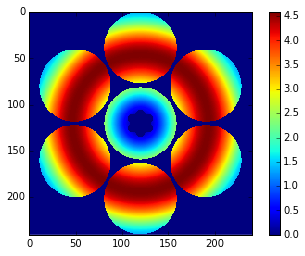

In [9]:
#xyz0 = rays.coordinates.host()
optical_system(res.x,src,sphere_radius)
imshow(1e9*src.phase.host(),interpolation='None')
colorbar()
#imgr0 = ceo.Imaging(1, nPx-1 ,DFT_osf=8,N_PX_IMAGE=75)
#imgr0.propagate(onAxis)
wfs.calibrate(src,0.75)
imgr.calibrate(src,0.0)

In [10]:
src.wavefront.piston()*1e9

3.3701981205780385

In [11]:
src.wavefront.piston(mask=M1.piston_mask)*1e9

array([ 3.65800071,  3.6561923 ,  3.65617752,  3.65799379,  3.65619373,
        3.65617371,  1.44682479], dtype=float32)

In [13]:
def ray_trace(mirror='M1',T=[0,0,0],O=[0,0,0],segId=0):
    
    print "IMAGER pixel scale  : %5.2fmas"%(1e3*imgr.pixel_scale_arcsec)
    print "IMAGER field-of-view: %5.2fmas"%(1e3*imgr.pixel_scale_arcsec*nPx*2)
    print "WFS pixel scale     : %5.2fmas"%(1e3*wfs.pixel_scale_arcsec)
    print "WFS field-of-view   : %5.2fmas"%(1e3*wfs.pixel_scale_arcsec*n*2)
    
    if mirror=="M1":
        M1.update(origin=T,euler_angles=O,idx=segId)
    if mirror=="M2":
        M2.update(origin=T,euler_angles=O,idx=segId)
    src.reset()
    
    optical_system(res.x,src,sphere_radius)

    imgr.reset()
    tid.tic()
    imgr.propagate(src)
    tid.toc()
    
    wfs.reset()
    wfs.analyze(src)
    print np.median(wfs.c.host(units='arcsec'))

   # fig, ((ax1,ax2),(ax3,ax4)) = subplots(nrows=2, ncols=2)
    fig = figure()
    fig.set_size_inches(20,25)
    
    ax1 = subplot2grid( (3,2), (0,0))
    """
    xf = xyzf[:,0]
    yf = xyzf[:,1]
    ax1.plot(xf[P1D>0]*1e6,yf[P1D>0]*1e6,'.')
    ax1.grid()
    ax1.set_aspect(aspect=1)
    ax1.set_xlabel('X [micron]')
    ax1.set_ylabel('Y [micron]')
    ax1.set_title('Spot diagram @ focus')
    """
    
    #opd = np.reshape(rays.optical_path_difference.host()*1e9,(n_radius,n_radius))
    opd = src.phase.host(units='nm')
    ax2 = subplot2grid( (3,2), (0,1))
    hi = ax2.imshow(opd,interpolation='none',origin='lower')
    h = colorbar(hi,ax=ax2)
    h.set_label('OPD [nm]')
    grid()
    ax2.set_title( "WFE [nm]: RMS %4.2f"%(1e9*src.wavefront.rms()) )
#    ax2.set_title( "WFE [nm]: RMS %4.2f & PtV %4.2f"%(np.std(opd[P>0]),(np.max(opd[P>0]) - np.min(opd[P>0]))))
    
    ax3 = subplot2grid( (3,2), (1,0))
    lim = nPx*imgr.pixel_scale_arcsec
    h3 = ax3.imshow((imgr.frame.host()),interpolation='none',extent=[-lim,lim,-lim,lim],origin='lower')
    ax3.grid()
    ax3.set_xlabel('X [arcsec]')
    ax3.set_ylabel('Y [arcsec]')
    psf_c = imgr.c.host(units='arcsec')
    ax3.set_title("[Cx,Cy]=[%4.2f,%4.2f]arcsec"%(psf_c[0,0],psf_c[0,1]))
    colorbar(h3,ax=ax3)
    
    ax4 = subplot2grid( (3,2), (1,1))
    h4 = ax4.imshow((wfs.frame.host()),interpolation='none')
    colorbar(h4,ax=ax4)
    
    ax5 = subplot2grid( (3,2), (2,0),colspan=2)
    h5 = imshow(1e3*wfs.c.host(units='arcsec').reshape(2*nLenslet
                                ,nLenslet).transpose(),interpolation='none')
    hc5 = colorbar(h5,ax=ax5)
    hc5.set_label('centroids [mas]')
    
    fig.tight_layout()

IMAGER pixel scale  :  1.29mas
IMAGER field-of-view: 623.81mas
WFS pixel scale     : 77.65mas
WFS field-of-view   : 1242.44mas
0.0


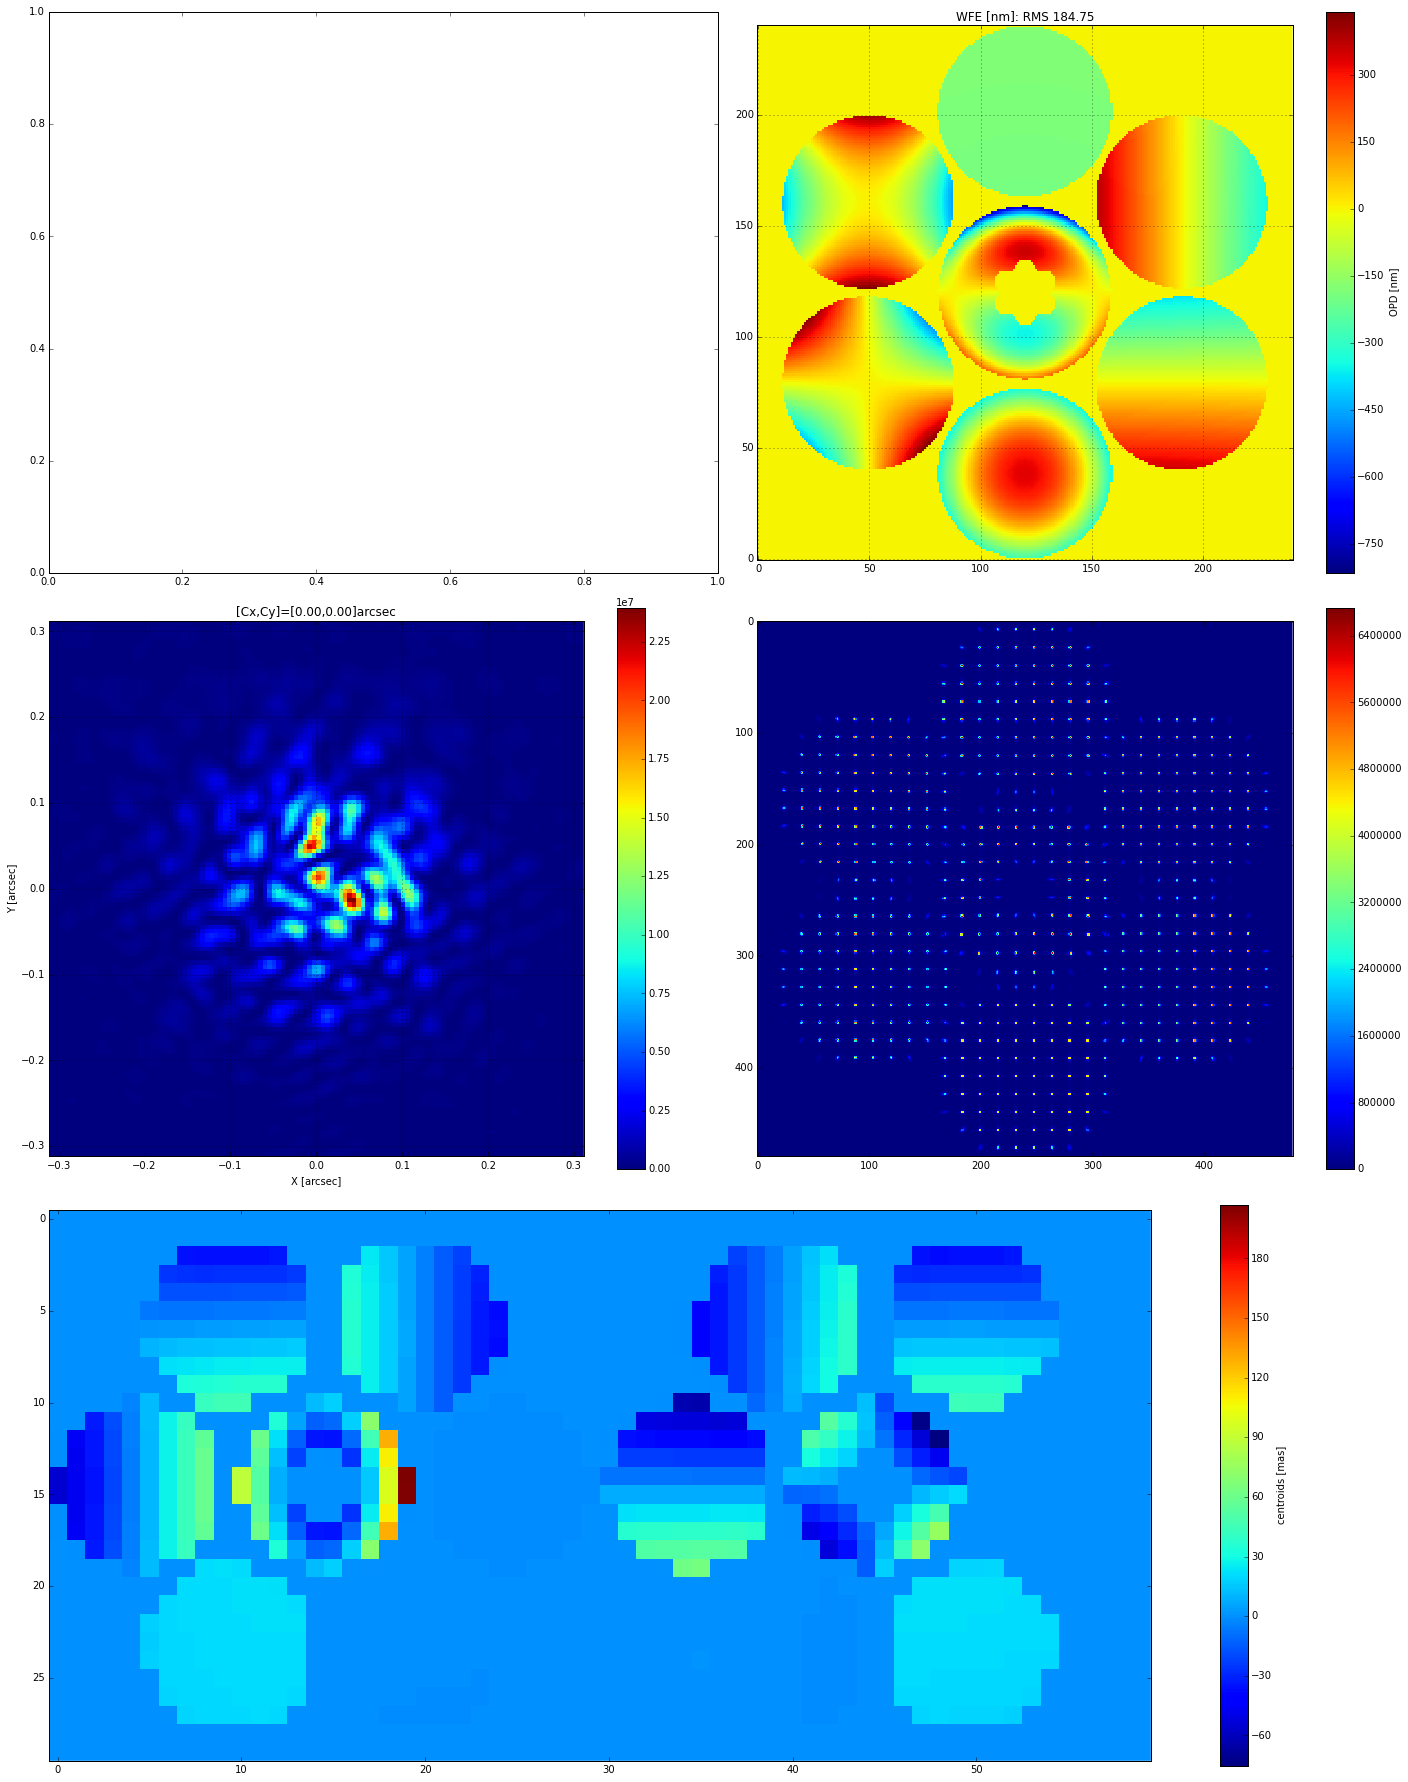

In [14]:
mas2rad = 1e-3*math.pi/180/3600
M1.reset()
M2.reset()
#M1.global_tiptilt(0.*math.pi/180/3600.0,1.*math.pi/180.0/3600)
M1.zernike.reset()
M2.zernike.reset()
for k in range(7):
    M1.zernike.a[k,k] = 1e-7
#M1.zernike.a[2,4] = 0e-7
M1.zernike.update()
#M2.zernike.a[2,4] = 1e-7
M2.zernike.update()
ray_trace(mirror='M1',T=[0e-3,0e-2,0e-9],O=[x*mas2rad for x in [0,0,0]],segId=7)

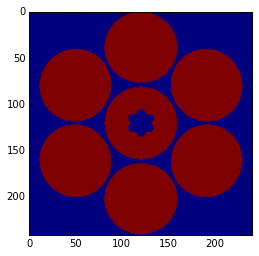

In [12]:
fig = imshow(src.rays.vignetting.host().reshape(nPx,nPx))

<matplotlib.colorbar.Colorbar instance at 0x2adc2789b200>

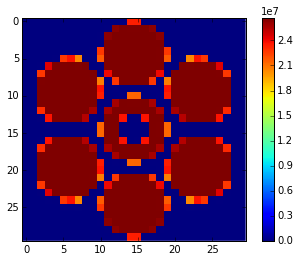

In [13]:
imshow(wfs.flux.host(),interpolation='none')
colorbar()

In [14]:
def get_slopes(mirror='M1',T=[0,0,0],O=[0,0,0],segId=0):
    
    M1.reset()
    M2.reset()
    if mirror=="M1":
        M1.update(origin=T,euler_angles=O,idx=segId)
    if mirror=="M2":
        M2.update(origin=T,euler_angles=O,idx=segId)
    src.reset()
    
    src.stop(M2)
    src.trace(M1)
    src.trace(M2)
    src.rays.go_sphere(res.x,sphere_radius)
    
    src.opd2phase()    
        
    P = src.rays.vignetting.host()
    P1D = P.ravel(0)
    P = np.reshape(P,(n_radius,n_radius))
    
#    """
    ox = np.tan(src.zenith)*np.cos(src.azimuth)
    oy = np.tan(src.zenith)*np.sin(src.azimuth)
    u = linspace(-1,1,nPx)
    xx,yy = meshgrid(u,u)
    wfs_offset = P*(ox*xx + oy*yy)*D/2
    cu_wfs_offset = ceo.cuFloatArray(host_data=wfs_offset)
    src.phase = cu_wfs_offset
#    """
    
    wfs.reset()
    wfs.analyze(src)
    return wfs.c.host(units='arcsec')

(1, 1800)
904.0


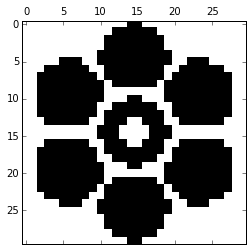

In [16]:
VL = wfs.valid_lenslet.f.host()
spy(VL.reshape((nLenslet,nLenslet)))
VL = np.tile(VL.reshape((1,900)),2)
print VL.shape
nvl = VL.sum()
print nvl
mask = VL>0

In [16]:
stroke = {"M1 tilt": 50, "M2 tilt": 400}
tid.tic()
for M in ["M1","M2"]:
    print M
    tilt = stroke[M+" tilt"]
    for k in range(7):
        print " . Segment #%d"%(k)
        sk_ox = get_slopes(mirror='M1',T=[0,0,0],O=[x*mas2rad for x in [tilt,0,0]],segId=k)/tilt
        if (k==0) and (M=="M1"):
            s = sk_ox[mask].reshape((nvl,1))
        else:
            s = np.concatenate((s,sk_ox[mask].reshape((nvl,1))),1)                            
        sk_oy = get_slopes(mirror='M1',T=[0,0,0],O=[x*mas2rad for x in [0,tilt,0]],segId=k)/tilt
        s = np.concatenate((s,sk_oy[mask].reshape((nvl,1))),1)
tid.toc()
print s.shape
#imshow(s)

M1
 . Segment #0
 . Segment #1
 . Segment #2
 . Segment #3
 . Segment #4
 . Segment #5
 . Segment #6
M2
 . Segment #0
 . Segment #1
 . Segment #2
 . Segment #3
 . Segment #4
 . Segment #5
 . Segment #6
(904, 28)


In [ ]:
U,ev,V = np.linalg.svd(s, full_matrices=False)

In [ ]:
U.shape

In [ ]:
iS = np.dot(V.T, np.dot(np.diag(1./ev), U.T))

In [ ]:
semilogy(ev,'.')
grid()

In [14]:
#print np.array_str(np.dot(iS,s),precision=6,suppress_small=True)

In [15]:
ZS1.a.shape

(7, 66)